In [73]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
x = 10
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [75]:
if torch.cuda.is_available():
    print("Cuda is available")
else:
    if 'cpu' in torch.__version__:
        print("NOT using cuda, torch version is +cpu instead of +cu")
    else:
        print("NOT using cuda, assert torch.cuda.is_available() failed")

Cuda is available


In [76]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None, verbose = False) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        if verbose:
            print("Forward pass now ~~~~~~~~~~~~~~~~")
            print("Shape of input:", src.shape)
            print(src)
        src = self.embedding(src) * math.sqrt(self.d_model)
        if verbose:
            print("Shape after embedding:", src.shape)
            print(src)
        src = self.pos_encoder(src)
        if verbose:
            print("Shape after positional encoding:", src.shape)
            print(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        if verbose:
            print("Shape of mask:", src_mask.shape)
            print(src_mask)
        output = self.transformer_encoder(src, src_mask)
        if verbose:
            print("Shape after transformer encoding:", output.shape)
            print(output)
        output = self.linear(output)
        if verbose:
            print("Shape after linear:", output.shape)
            print(output)
        return output
    
    def __call__(self, src: Tensor, src_mask: Tensor = None, verbose = False) -> Tensor:
        return self.forward(src, src_mask = None, verbose = verbose)
    
    

In [77]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        # print("PE: Shape of input to PosEnc.forward():", x.shape)
        # print("PE: Shape of self.pe[:x.size(0)]:", self.pe[:x.size(0)].shape)
        x = x + self.pe[:x.size(0)].squeeze(1)
        # print("PE: Shape of output after adding PE:", x.shape)
        # print("PE: Shape of output after dropout:", self.dropout(x).shape)
        return self.dropout(x)
    
    def __call__(self, x: Tensor) -> Tensor:
        return self.forward(x)
    

In [78]:
# %pip install portalocker
# %pip install torchdata

In [79]:
# %%bash
# pip install torchtext

In [80]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    print('batch size, seq_len: ', bsz, seq_len)
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

batch size, seq_len:  20 102499
batch size, seq_len:  10 21441
batch size, seq_len:  10 24185


In [81]:
train_data = data_process(train_iter)
train_data = train_data.to(device)

val_data = data_process(val_iter)
val_data = val_data.to(device)

test_data = data_process(test_iter)
test_data = test_data.to(device)

len(train_data)

2049990

In [82]:
train_data

tensor([   9, 3849, 3869,  ..., 2442, 4810,    3], device='cuda:0')

In [83]:
# bptt = 256
# bptt = 1024
bptt = 2048
# bptt = 3072
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [84]:
optimizer, scheduler = None, None

In [85]:
import time
train_accelerate_factor = 1

criterion = nn.CrossEntropyLoss()

def train(model: nn.Module, verbose=False) -> None:
    
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 100
    start_time = time.time()

    train_losses = []

    num_batches = len(train_data) // bptt
    print('batch size = ', bptt, '; number of batches = ', num_batches)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        if batch % train_accelerate_factor != 0:
            continue
        data, targets = get_batch(train_data, i)
        data, targets = data.to(device), targets.to(device)

        output = model(data, verbose=verbose)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
    
        total_loss += loss.item()
        if batch % log_interval == 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            start_time = time.time()
            cur_loss = total_loss / log_interval
            train_losses.append(cur_loss)
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0

    return train_losses

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            data = data.to(device)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
            # total_loss += criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [86]:
ntokens = len(vocab)  # size of vocabulary
emsize = 50  # embedding dimension (default 200)
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

In [87]:
lr = 0.25  # learning rate

In [88]:
def new_model():
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
    return model, optimizer, scheduler

In [89]:
model, optimizer, scheduler = new_model()

data, targets = get_batch(train_data, 0)
data, targets = data.to(device), targets.to(device)

output = model(data, verbose=False)

In [90]:
import time
import numpy as np
best_val_loss = float('inf')
epochs = 1000
save_model_epochs = 10
model, optimizer, scheduler = new_model()
# model_file_name = './data/model_epoch_10.pth'
# model.load_state_dict(torch.load(model_file_name))

train_losses = []
val_losses = []

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(0, epochs):
        epoch_start_time = time.time()

        train_losses_temp = train(model, verbose=False)
        train_losses += train_losses_temp

        val_loss = evaluate(model, val_data)
        val_losses += [val_loss]
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
              f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if epoch % save_model_epochs == 0:
            # time_stamp = str(time.strftime("%Y-%m-%d_%H:%M:%S"))
            model_file_name = './data/model_epoch_'+str(epoch)+'.pth'
            torch.save(model.state_dict(), model_file_name)
            train_losses_file_name = './data/train_losses_epoch'+str(epoch)+'.csv'
            train_loss_out = np.array(train_losses)
            train_loss_out.tofile(train_losses_file_name, sep=',', format='%0.4f')
            val_losses_file_name = './data/val_losses_epoch'+str(epoch)+'.csv'
            val_loss_out = np.array(val_losses)
            val_loss_out.tofile(val_losses_file_name, sep=',', format='%0.4f')
        scheduler.step()

batch size =  2048 ; number of batches =  1000
| epoch   0 |     0/ 1000 batches | lr 0.25 | ms/batch  0.54 | loss  0.10 | ppl     1.11
| epoch   0 |   100/ 1000 batches | lr 0.25 | ms/batch  0.70 | loss  0.25 | ppl     1.29
| epoch   0 |   200/ 1000 batches | lr 0.25 | ms/batch  0.72 | loss  0.34 | ppl     1.40
| epoch   0 |   300/ 1000 batches | lr 0.25 | ms/batch  0.70 | loss  0.25 | ppl     1.28
| epoch   0 |   400/ 1000 batches | lr 0.25 | ms/batch  0.71 | loss  0.30 | ppl     1.35
| epoch   0 |   500/ 1000 batches | lr 0.25 | ms/batch  0.66 | loss  0.23 | ppl     1.26
| epoch   0 |   600/ 1000 batches | lr 0.25 | ms/batch  0.61 | loss  0.18 | ppl     1.20
| epoch   0 |   700/ 1000 batches | lr 0.25 | ms/batch  0.61 | loss  0.18 | ppl     1.20
| epoch   0 |   800/ 1000 batches | lr 0.25 | ms/batch  0.61 | loss  0.17 | ppl     1.19
| epoch   0 |   900/ 1000 batches | lr 0.25 | ms/batch  0.61 | loss  0.17 | ppl     1.18
| epoch   0 |  1000/ 1000 batches | lr 0.25 | ms/batch  0.66 | 

KeyboardInterrupt: 

In [ ]:
train_losses_file_name = './'+'train_losses_epoch'+str(epoch)+'.csv'
lossesscv = np.array(train_losses).round(3)
print(lossesscv)
# np.savetxt(train_losses_file_name, lossesscv, delimiter=",")
lossesscv.tofile(train_losses_file_name,sep=',',format='%0.4f')

[0.083 0.252 0.179 0.073 0.088 0.1   0.109 0.096 0.085 0.081 0.075 0.086
 0.081 0.087 0.071 0.066 0.08  0.077 0.086 0.084 0.074 0.085 0.092 0.086
 0.081 0.084 0.089 0.091 0.078 0.075 0.077 0.075 0.082 0.084 0.09  0.091
 0.083 0.075 0.074 0.078 0.082 0.085 0.085 0.079 0.078 0.076 0.083 0.084
 0.083 0.074 0.067 0.065 0.072 0.073 0.073 0.08  0.076 0.075 0.07  0.069
 0.069 0.069 0.068 0.074 0.079 0.079]


In [ ]:
np.array(train_losses).round(3)

array([0.083, 0.252, 0.179, 0.073, 0.088, 0.1  , 0.109, 0.096, 0.085,
       0.081, 0.075, 0.086, 0.081, 0.087, 0.071, 0.066, 0.08 , 0.077,
       0.086, 0.084, 0.074, 0.085, 0.092, 0.086, 0.081, 0.084, 0.089,
       0.091, 0.078, 0.075, 0.077, 0.075, 0.082, 0.084, 0.09 , 0.091,
       0.083, 0.075, 0.074, 0.078, 0.082, 0.085, 0.085, 0.079, 0.078,
       0.076, 0.083, 0.084, 0.083, 0.074, 0.067, 0.065, 0.072, 0.073,
       0.073, 0.08 , 0.076, 0.075, 0.07 , 0.069, 0.069, 0.069, 0.068,
       0.074, 0.079, 0.079])

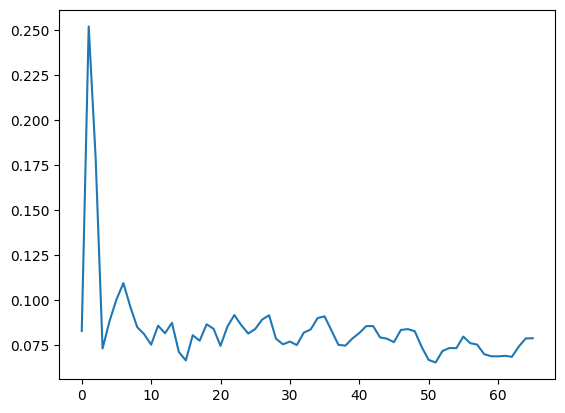

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.show()

In [ ]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  8.70 | test ppl  6020.76


In [ ]:
print("Train:")
print(train_data)
print(train_data.shape)
print(evaluate(model, train_data))

print("Validation:")
print(val_data)
print(val_data.shape)
print(evaluate(model, val_data))

print("Test:")
print(test_data)
print(test_data.shape)
print(evaluate(model, test_data))

Train:
tensor([   9, 3849, 3869,  ..., 2442, 4810,    3], device='cuda:0')
torch.Size([2049990])
9.187452700594196
Validation:
tensor([    9,  9606, 25610,  ...,     9,     9,     9], device='cuda:0')
torch.Size([214417])
8.768819147130907
Test:
tensor([   9,  632,    0,  ..., 7213,    0,    3], device='cuda:0')
torch.Size([241859])
8.702968146449683


In [ ]:
from datetime import datetime

In [ ]:
datetime.now()

datetime.datetime(2023, 12, 30, 2, 2, 48, 741089)

In [ ]:
import time
time_stamp = time.strftime("%Y-%m-%d_%H:%M:%S")
fname = time_stamp+'_epoch'
print(fname)

2023-12-30_02:02:48_epoch


In [ ]:

print(time_stamp)


2023-12-30_02:02:48


In [ ]:
# torch.cuda.current_device()     # The ID of the current GPU.
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4070 Laptop GPU'